## Implementation ml-task for package version

In [1]:
%env CUBLAS_WORKSPACE_CONFIG=:16:8

env: CUBLAS_WORKSPACE_CONFIG=:16:8


In [2]:
## Running Autoencodix training
import autoencodix as acx
from autoencodix.utils.default_config import DefaultConfig
from autoencodix.utils.default_config import DataCase
from autoencodix.data.datapackage import DataPackage
import pandas as pd

df_rna = pd.read_parquet("./input_data_test/combined_rnaseq_formatted.parquet")
df_meth = pd.read_parquet("./input_data_test/combined_meth_formatted.parquet")
df_anno = pd.read_parquet("./input_data_test/combined_clin_formatted.parquet")

data_package = DataPackage()
data_package.multi_bulk = {"transcriptomics": df_rna, "epigenetic": df_meth}
data_package.annotation = {
	"paired": df_anno.copy(),
}

ont_files = [
	# Order from Latent Dim -> Hidden Dim -> Input Dim
	"./input_data_test/chromosome_ont_lvl2.txt",
	"./input_data_test/chromosome_ont_lvl1_ncbi.txt",
	]

my_cfg = DefaultConfig(
	data_case=DataCase.MULTI_BULK,
	loss_reduction="sum",
	k_filter=2000,
	scaling="STANDARD",
	filtering="VAR",
	epochs=300,
	learning_rate=0.0005,
	batch_size = 128,
	beta = 0.5,
	drop_p =0.3,
	n_layers=1)

# var = acx.Varix(data=data_package, config=my_cfg)
# var = acx.Vanillix(data=data_package, config=my_cfg)
var = acx.Ontix(ontologies=ont_files, sep="\t", config=my_cfg, data=data_package)



/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>


In [3]:
var.run()

 n_samples: {'multi_sc': {'multi_sc': 0}, 'multi_bulk': {'transcriptomics': 3529, 'epigenetic': 3529}, 'annotation': {'paired': 3529}, 'img': {'img': 0}, 'from_modality': {}, 'to_modality': {}, 'paired_count': {'paired_count': 3529}}
Features in feature_order not found in all_feature_names: ['100133144', '10357', '10431', '155060', '390284', '57714', '645851', '653553', '729884', '246182', '119385', '653268', '728404', '200810', '138649', '441425', '728747', '729171', '23520', '303', '304', '305', '244', '375719', '441432', '503640', '641522', '432369', '92270', '6791', '85319', '606', '23629', '286076', '414235', '170393', '255352', '283422', '283416', '374467', '84837', '400223', '650662', '280655', '283651', '80035', '283687', '196968', '284185', '147429', '147525', '494514', '574036', '284573', '149469', '84791', '253868', '284836', '54094', '54067', '282566', '114041', '114043', '149992', '55267', '29798', '348738', '339942', '93556', '646450', '317648', '92070', '79614', '153571'

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: OntixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x72d7759b7520>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x72d7759b7430>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x72d778f96590>)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 706 × 25
    uns: 'var_names'
final_reconstru

Creating plots ...


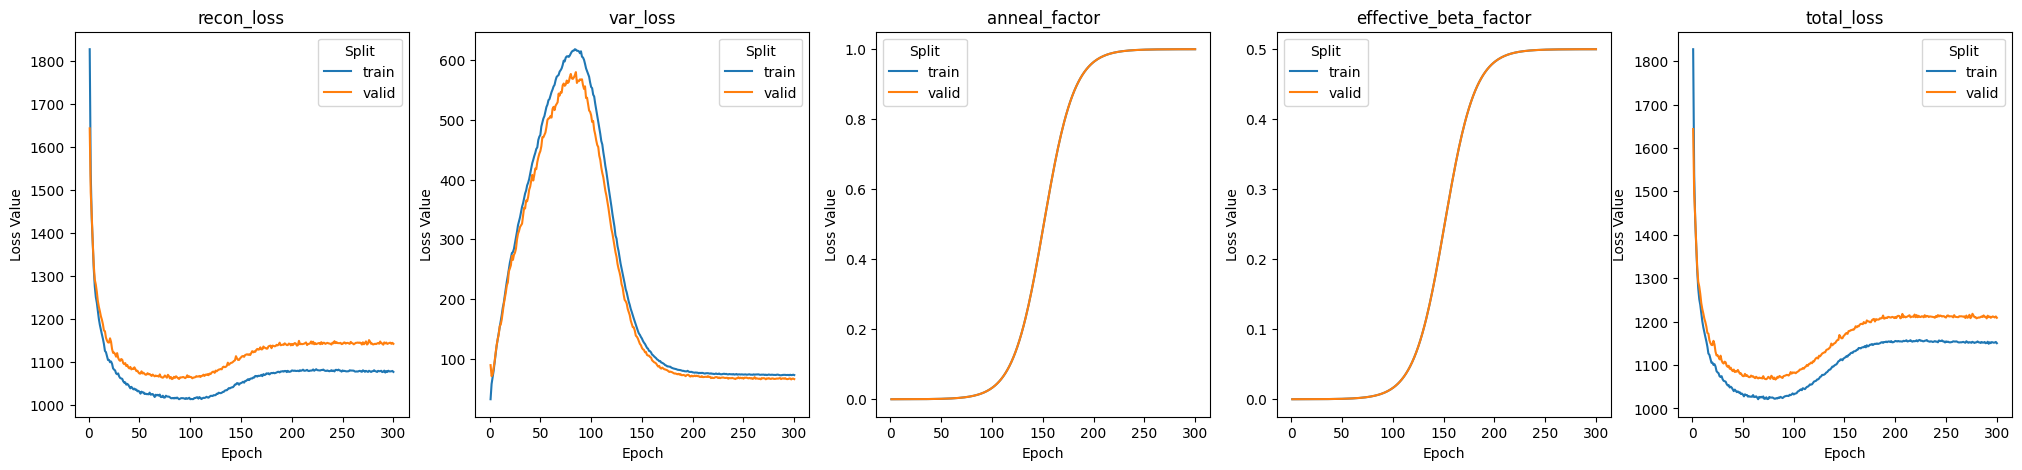

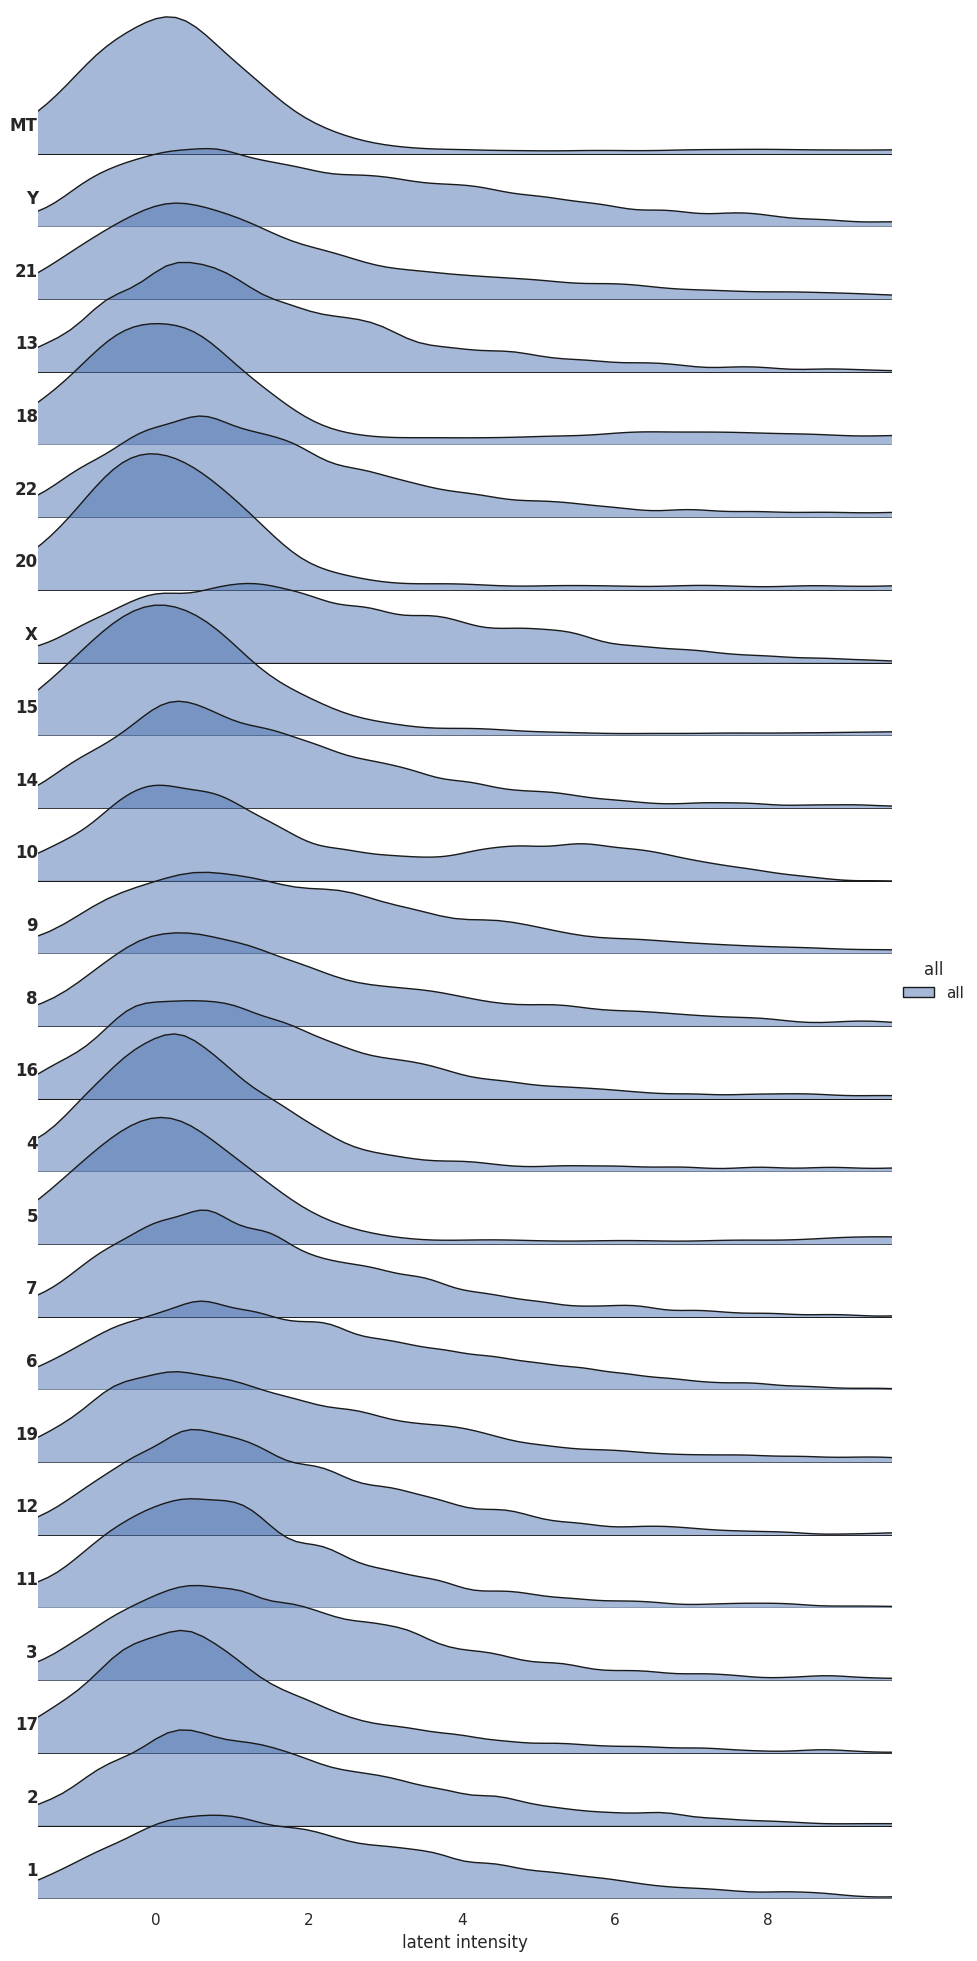

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


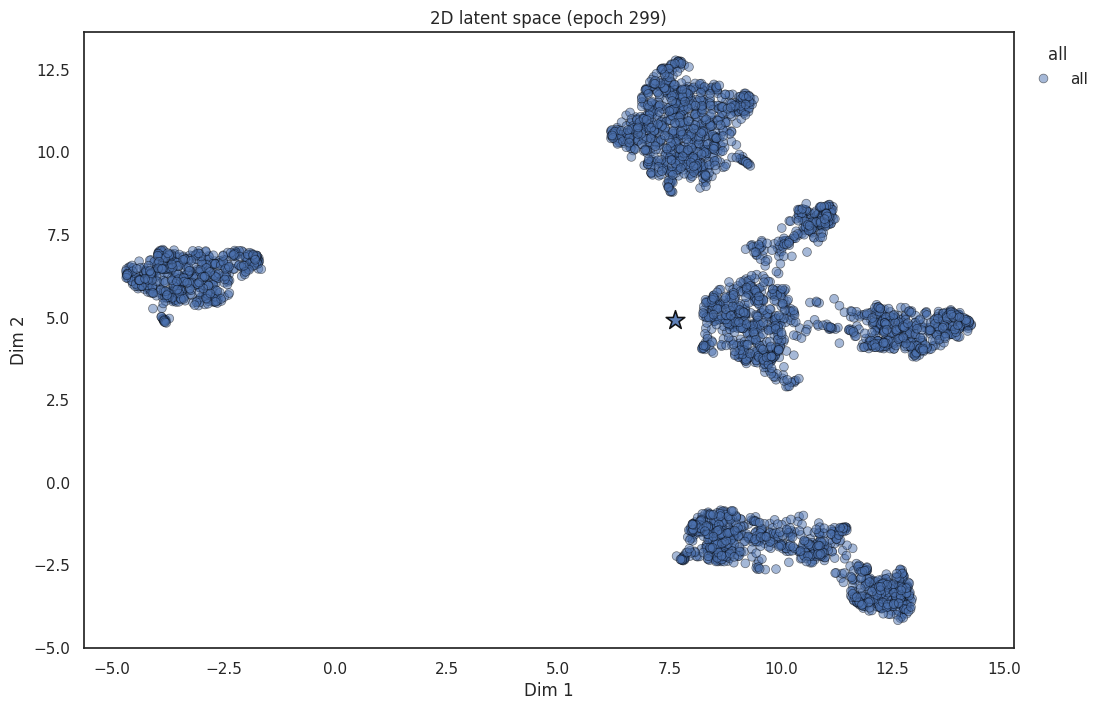

In [4]:
var.show_result()

In [5]:
## Evaluation
from sklearn import linear_model
sklearn_ml_class = linear_model.LogisticRegression(
							solver="sag",
							n_jobs=-1,
							class_weight="balanced",
							max_iter=200,
) ## Support of all sklearn-like models
sklearn_ml_regression = linear_model.LinearRegression()
own_metric_class = 'roc_auc_ovr'  ## sklearn name of metrics: https://scikit-learn.org/stable/modules/model_evaluation.html#string-name-scorers
own_metric_regression = 'r2' 

var.evaluate(
	ml_model_class=sklearn_ml_class, # Default is sklearn LogisticRegression
	ml_model_regression=sklearn_ml_regression, # Default is sklearn LinearRegression
	params= ["CANCER_TYPE", "SEX","AGE"],	# No default? ... or all params in annotation?
	metric_class = own_metric_class, # Default is 'roc_auc_ovr'
	metric_regression = own_metric_regression, # Default is 'r2'
	reference_methods = ["PCA", "UMAP", "RandomFeature"], # Default [], no references? or all possible? or only PCA?
	split_type = "use-split", # Default is "use-split", other options: "CV-5", ... "LOOCV"?

)

## Dataframe of evaluation results
print(var.result.embedding_evaluation)




Perform ML task with feature df: PCA


/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


There are NA values in the annotation file. Samples with missing data will be removed for ML task evaluation.
Perform ML task with feature df: UMAP


/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Perform ML task with feature df: RandomFeature


/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means

Perform ML task with feature df: Latent
Perform ML task for target parameter: CANCER_TYPE


/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Perform ML task for target parameter: SEX


/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Perform ML task for target parameter: AGE
   score_split CLINIC_PARAM       metric     value  \
0        train  CANCER_TYPE  roc_auc_ovr  0.999959   
1        valid  CANCER_TYPE  roc_auc_ovr  1.000000   
2         test  CANCER_TYPE  roc_auc_ovr  0.999760   
0        train          SEX  roc_auc_ovr  0.897785   
1        valid          SEX  roc_auc_ovr  0.929941   
..         ...          ...          ...       ...   
1        valid          SEX  roc_auc_ovr  0.958611   
2         test          SEX  roc_auc_ovr  0.943892   
0        train          AGE           r2  0.131741   
1        valid          AGE           r2  0.111234   
2         test          AGE           r2  0.110607   

                                               ML_ALG         ML_TYPE ML_TASK  \
0   LogisticRegression(class_weight='balanced', ma...  classification     PCA   
1   LogisticRegression(class_weight='balanced', ma...  classification     PCA   
2   LogisticRegression(class_weight='balanced', ma...  classificat

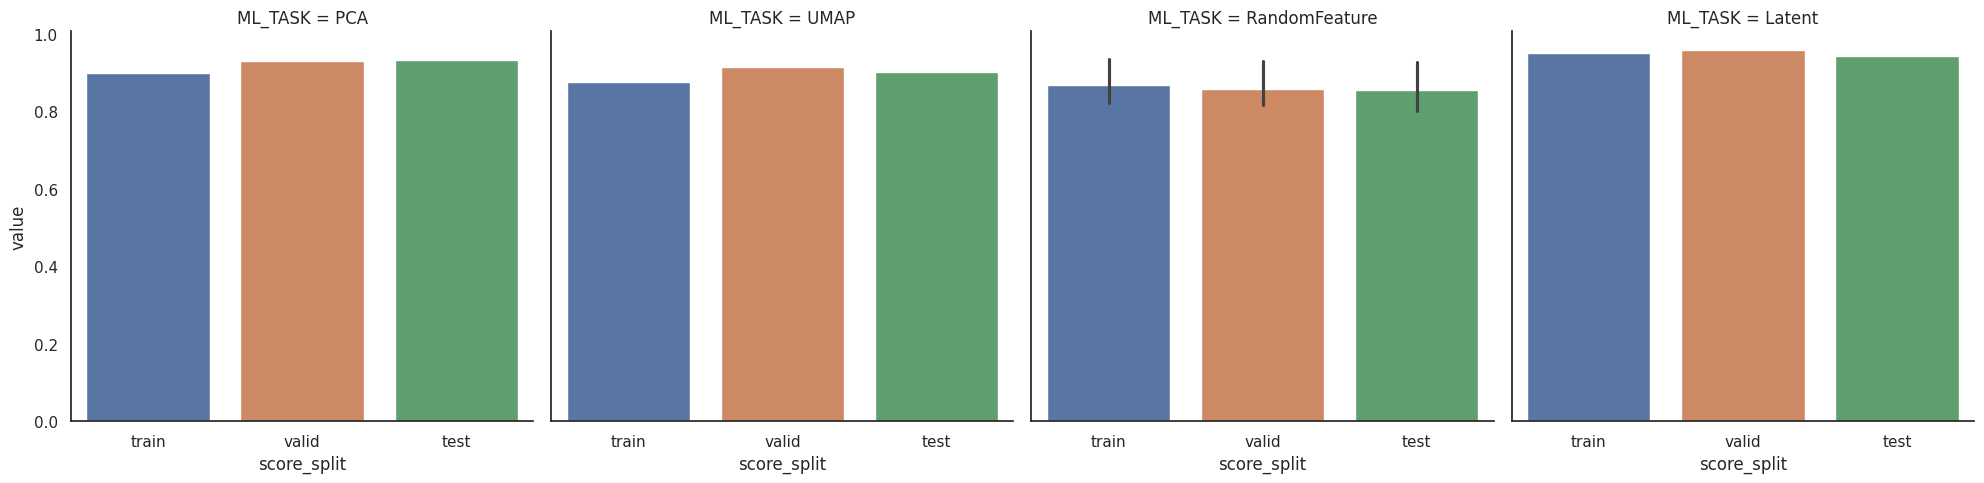

In [16]:
# barplot of evaluation results
var._visualizer.show_evaluation(
	param = "SEX",
	metric = own_metric_class, 
	ml_alg=str(sklearn_ml_class),
)

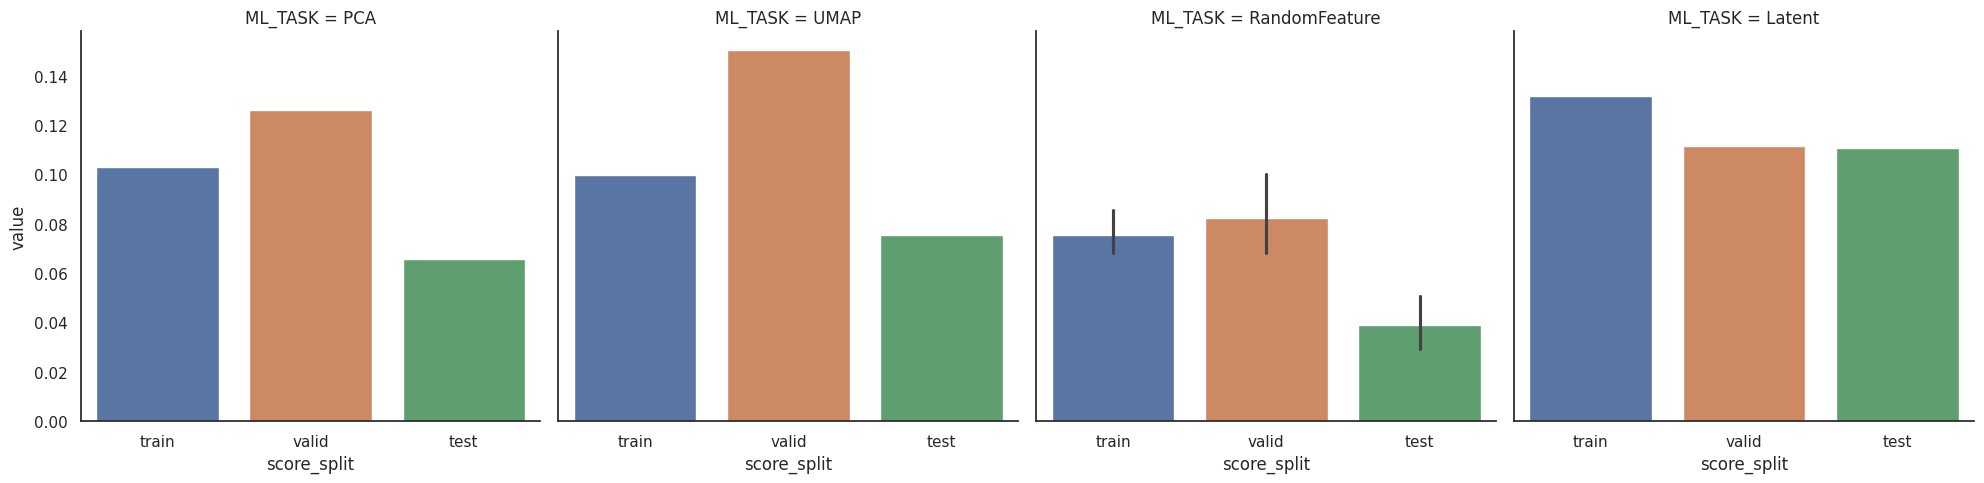

In [17]:
# barplot of evaluation results
var._visualizer.show_evaluation(
	param = "AGE",
	metric = own_metric_regression, 
	ml_alg=str(sklearn_ml_regression),
)

## Test using TabPFN as non-sklearn ML model, but with sklearn-like API

In [7]:
## Variable needs to set otherwise an error occurs when importing scipy
%env SCIPY_ARRAY_API=1

env: SCIPY_ARRAY_API=1


In [8]:
from tabpfn import TabPFNClassifier, TabPFNRegressor

tabpfn_class = TabPFNClassifier()
tabpfn_regress = TabPFNRegressor()

In [9]:
var.evaluate(
	ml_model_class=tabpfn_class, # Default is sklearn LogisticRegression
	ml_model_regression=tabpfn_regress, # Default is sklearn LinearRegression
	params= ["CANCER_TYPE", "SEX" ,"AGE"],	# No default? ... or all params in annotation?
	metric_class = own_metric_class, # Default is 'roc_auc_ovr'
	metric_regression = own_metric_regression, # Default is 'r2'
	reference_methods = ["PCA", "UMAP", "RandomFeature"], # Default [], no references? or all possible? or only PCA?
	split_type = "use-split", # Default is "use-split", other options: "CV-5", ... "LOOCV"?

)

Perform ML task with feature df: PCA
There are NA values in the annotation file. Samples with missing data will be removed for ML task evaluation.
Perform ML task with feature df: UMAP


/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Perform ML task with feature df: RandomFeature
Perform ML task with feature df: Latent
Perform ML task for target parameter: CANCER_TYPE
Perform ML task for target parameter: SEX
Perform ML task for target parameter: AGE


Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: OntixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x72d7759b7520>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x72d7759b7430>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x72d778f96590>)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 706 × 25
    uns: 'var_names'
final_reconstru

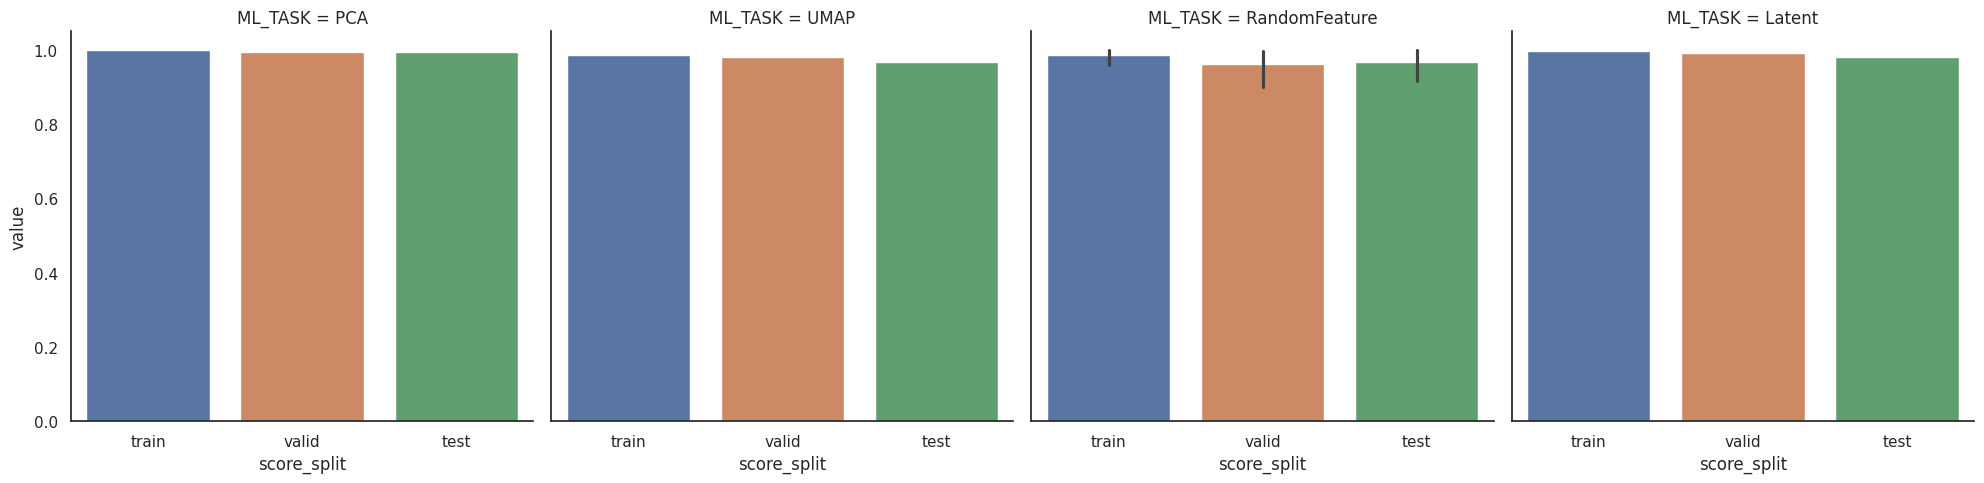

In [13]:
# barplot of evaluation results
var._visualizer.show_evaluation(
	param = "SEX",
	metric = own_metric_class,
	ml_alg=str(tabpfn_class), 
)

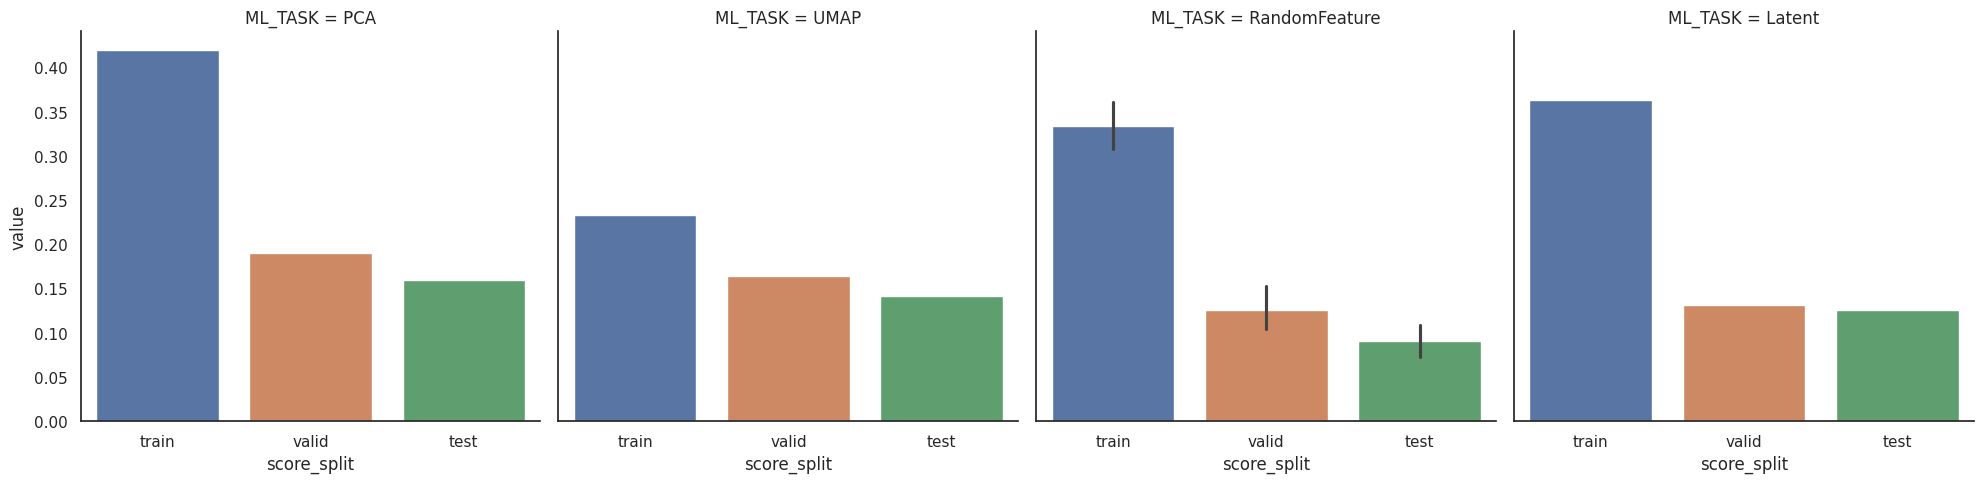

In [15]:
# barplot of evaluation results
var._visualizer.show_evaluation(
	param = "AGE",
	metric = own_metric_regression,
	ml_alg=str(tabpfn_regress), 
)

In [11]:
var.result.embedding_evaluation

,score_split,CLINIC_PARAM,metric,value,ML_ALG,ML_TYPE,ML_TASK,ML_SUBTASK
0,train,CANCER_TYPE,roc_auc_ovr,0.999959,"LogisticRegression(class_weight='balanced', ma...",classification,PCA,PCA
1,valid,CANCER_TYPE,roc_auc_ovr,1.000000,"LogisticRegression(class_weight='balanced', ma...",classification,PCA,PCA
2,test,CANCER_TYPE,roc_auc_ovr,0.999760,"LogisticRegression(class_weight='balanced', ma...",classification,PCA,PCA
0,train,SEX,roc_auc_ovr,0.897785,"LogisticRegression(class_weight='balanced', ma...",classification,PCA,PCA
1,valid,SEX,roc_auc_ovr,0.929941,"LogisticRegression(class_weight='balanced', ma...",classification,PCA,PCA
...,...,...,...,...,...,...,...,...
1,valid,SEX,roc_auc_ovr,0.992246,TabPFNClassifier(),classification,Latent,Latent
2,test,SEX,roc_auc_ovr,0.980655,TabPFNClassifier(),classification,Latent,Latent
0,train,AGE,r2,0.363546,TabPFNRegressor(),regression,Latent,Latent
1,valid,AGE,r2,0.131720,TabPFNRegressor(),regression,Latent,Latent
